In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo
import cmocean
import textwrap
import metpy.calc as mpcalc
from metpy.units import units

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain, plot_arscale_cbar
from colorline import colorline
from trajectory_post_funcs import calculate_heatmaps_from_trajectories
import customcmaps as ccmap


ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
HUC8_ID = '14010001'

In [4]:
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
ds = xr.open_dataset(fname)
ds = ds.sel(HUC8 = HUC8_ID)
ds = ds.sel(date = slice('2022-12-30', '2023-01-03'))
ds.prec.values/25.4

array([0.02242752, 0.21166299, 0.43501969, 0.13522323, 0.08485827])

In [5]:
## load trajectory from 2023 cases
fname = path_to_data + 'preprocessed/UCRB_trajectories/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
ds = xr.open_dataset(fname)
ds = ds.sel(start_date='2023-01-02')
ds

<xarray.Dataset>
Dimensions:       (start_lev: 1, grid: 1, index: 72)
Coordinates:
  * start_lev     (start_lev) float64 650.0
  * grid          (grid) <U6 'center'
    start_date    datetime64[ns] 2023-01-02
  * index         (index) int64 0 1 2 3 4 5 6 7 8 ... 63 64 65 66 67 68 69 70 71
Data variables:
    time          (start_lev, grid, index) datetime64[ns] ...
    latitude      (start_lev, grid, index) float64 ...
    longitude     (start_lev, grid, index) float64 ...
    level         (start_lev, grid, index) float64 ...
    q             (start_lev, grid, index) float64 ...
    u             (start_lev, grid, index) float64 ...
    v             (start_lev, grid, index) float64 ...
    w             (start_lev, grid, index) float64 ...
    dq            (start_lev, grid, index) float64 ...
    drying_ratio  (start_lev, grid, index) float64 ...

In [6]:
ds.time.values[0][0][29]

numpy.datetime64('2022-12-31T19:00:00.000000000')

In [7]:
ds.latitude.values[0][0][29]

31.980315574572785

In [8]:
ds.longitude.values[0][0][29]

-116.0529603374808

In [9]:
ds.level.values[0][0][29]

772.9351275793064

In [10]:
def roundPartial(value, resolution):
    return np.round(value / resolution) * resolution
test_y = roundPartial(ds.latitude.values, 0.25)
test_x = roundPartial(ds.longitude.values, 0.25)

test_y

array([[[40.  , 39.75, 39.5 , 39.  , 38.75, 38.25, 38.  , 37.5 , 37.  ,
         36.75, 36.5 , 36.  , 35.75, 35.25, 35.  , 34.5 , 34.  , 33.5 ,
         33.25, 33.  , 32.75, 32.5 , 32.25, 32.25, 32.  , 32.  , 32.  ,
         32.  , 32.  , 32.  , 32.  , 32.  , 32.  , 32.25, 32.25, 32.25,
         32.5 , 32.5 , 32.5 , 32.5 , 32.5 , 32.5 , 32.5 , 32.5 , 32.5 ,
         32.5 , 32.5 , 32.5 , 32.75, 32.75, 32.75, 32.75, 33.  , 33.  ,
         33.25, 33.25, 33.25, 33.5 , 33.5 , 33.5 , 33.5 , 33.5 , 33.5 ,
         33.5 , 33.5 , 33.25, 33.25, 33.25, 33.25, 33.  , 33.  , 33.  ]]])

In [11]:
test_x

array([[[-106.5 , -106.5 , -106.75, -107.  , -107.25, -107.5 , -107.5 ,
         -107.75, -108.  , -108.5 , -108.75, -109.25, -109.75, -110.25,
         -110.75, -111.25, -111.5 , -111.75, -112.25, -112.5 , -112.75,
         -113.25, -113.5 , -113.75, -114.  , -114.5 , -114.75, -115.25,
         -115.75, -116.  , -116.5 , -117.  , -117.5 , -118.  , -118.5 ,
         -119.  , -119.5 , -120.  , -120.5 , -121.  , -121.5 , -122.  ,
         -122.5 , -122.75, -123.25, -123.75, -124.  , -124.5 , -124.75,
         -125.25, -125.5 , -125.75, -126.25, -126.5 , -127.  , -127.5 ,
         -128.  , -128.5 , -129.  , -129.5 , -130.  , -130.5 , -131.  ,
         -131.75, -132.25, -132.75, -133.25, -133.75, -134.25, -134.75,
         -135.  , -135.5 ]]])

In [12]:
## load orography data
fname = path_to_data + 'downloads/ERA5/202212_z.nc'
terrain = xr.open_dataset(fname)
terrain = terrain.isel(time=0)
terrain = terrain.assign_coords({"longitude": (((terrain.longitude + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
# terrain = terrain.sel(latitude=slice(34.25, 27.25), longitude=slice(-118, -113)) # peninsular range
# terrain = terrain.sel(latitude=slice(38.50, 34.5), longitude=slice(-130, -117)) # transverse and sierras
terrain = terrain.sel(latitude=slice(40.5, 38.50), longitude=slice(-130, -118)) # end of sierras
# terrain = terrain.sel(latitude=slice(42, 40.50), longitude=slice(-130, -120.75)) # cascades
gph = terrain.z / 9.80665 # convert to geopotential height
gph.attrs = terrain.z.attrs
gph.attrs['units'] = 'm'

## get the coordinates of the maximum elevation
lon_lst = []
for i, lat in enumerate(gph.latitude.values):
    tmp = gph.sel(latitude=lat).idxmax() # get the index of the maximum elevation
    lon_lst.append(tmp.values) # grab the longitude value

## create a location dataarray with these coordinates and elevation
x = xr.DataArray(lon_lst, dims=['location'])
y = xr.DataArray(gph.latitude.values, dims=['location'])
test = gph.sel(longitude=x, latitude=y, method='nearest')
test

<xarray.DataArray 'z' (location: 9)>
array([1781.4681, 1673.9714, 1683.4025, 1779.2705, 1966.9772, 2056.161 ,
       2036.2916, 2189.4788, 2396.0479], dtype=float32)
Coordinates:
    latitude   (location) float32 40.5 40.25 40.0 39.75 ... 39.0 38.75 38.5
    time       datetime64[ns] 2022-12-29
    longitude  (location) float32 -121.2 -121.2 -120.2 ... -120.2 -120.0 -119.8
Dimensions without coordinates: location
Attributes:
    units:          m
    long_name:      Geopotential
    standard_name:  geopotential

In [13]:
test.latitude.values

array([40.5 , 40.25, 40.  , 39.75, 39.5 , 39.25, 39.  , 38.75, 38.5 ],
      dtype=float32)

In [14]:
test.longitude.values

array([-121.25, -121.25, -120.25, -120.5 , -120.25, -120.25, -120.25,
       -120.  , -119.75], dtype=float32)

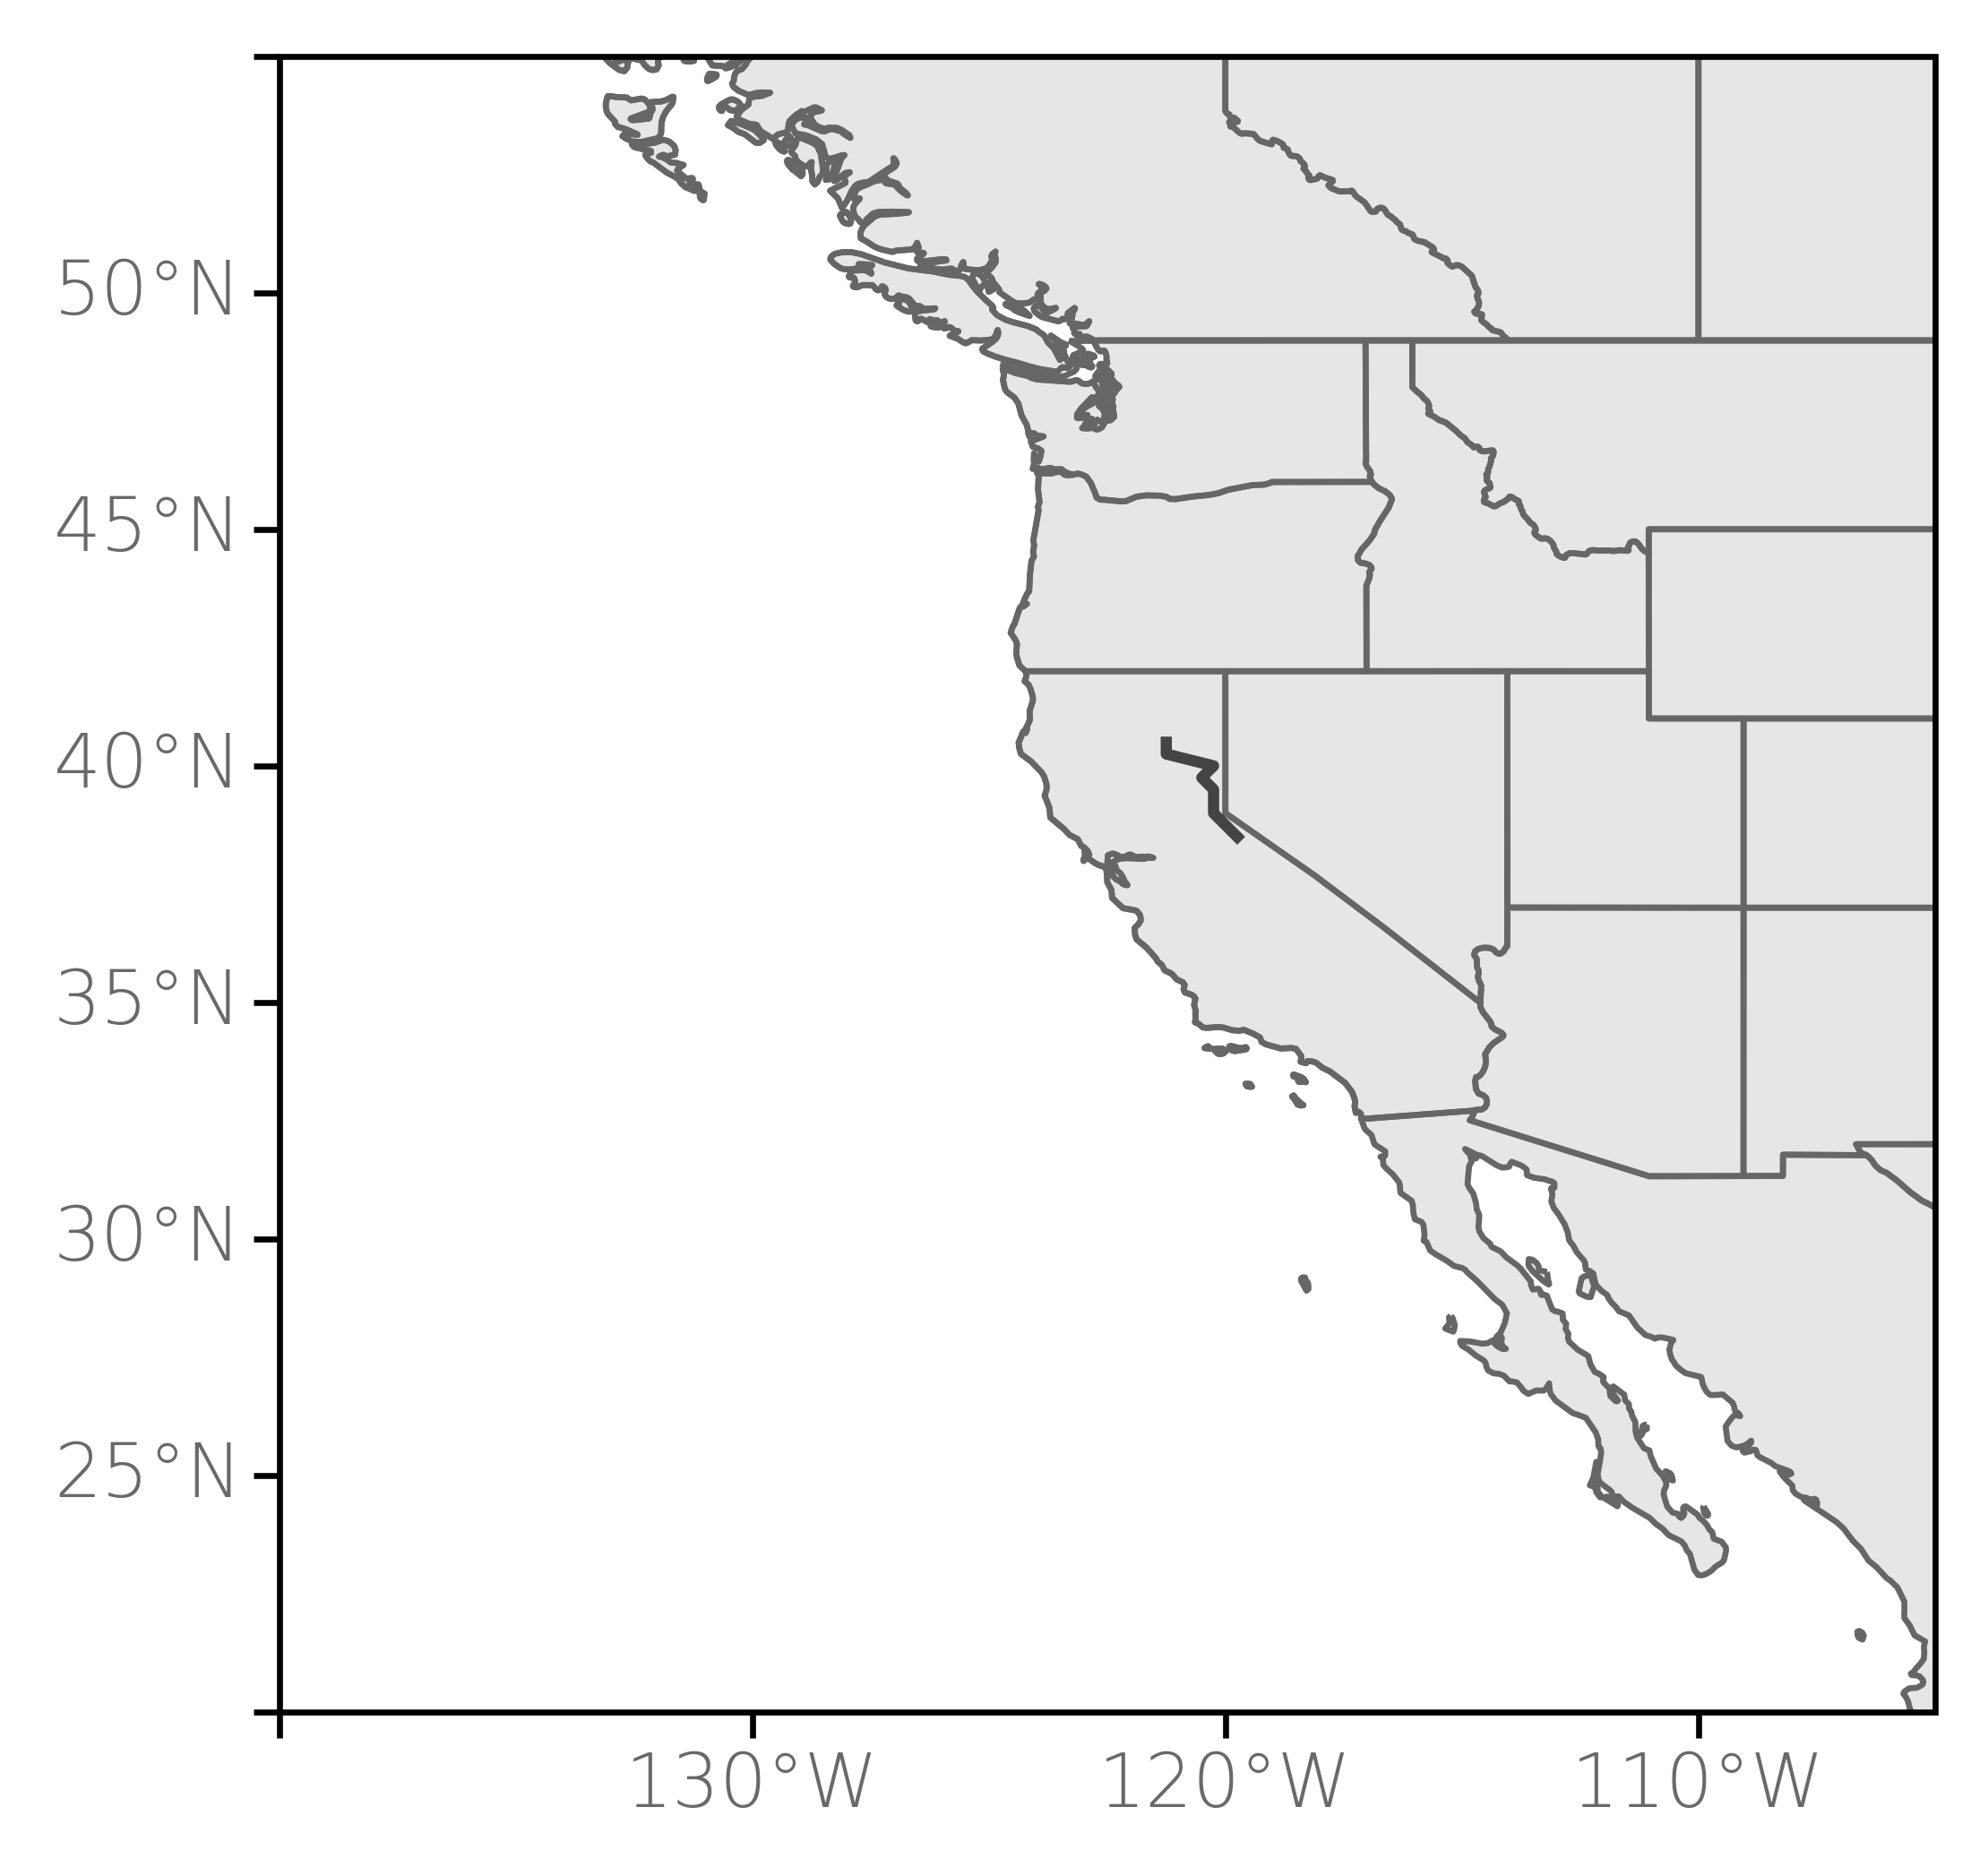

In [15]:
nrows = 1
ncols = 1
kw_ticklabels = {'size': 8, 'color': 'dimgray', 'weight': 'light'}
## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1], wspace=0.2, hspace=0.25)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(10.0, 4.0))
fig.dpi = 600
fname = path_to_figs + 'elevation_cross_section'
fmt = 'png'

############################
### PLOT IVT VALUES ###
############################
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in
ext = [-140., -105., 20., 55.]
# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

ax = fig.add_subplot(gs[0, 0], projection=mapcrs)
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False)
ax.set_extent(ext, datacrs)
## topo with gray shading
# cs = plot_terrain(ax, ext)
ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

## add elevation cross section points
# cf2 = ax.scatter(test.longitude.values, test.latitude.values, c='k', marker='.', transform=datacrs, alpha=0.8, s=30)
ax.plot(test.longitude.values, test.latitude.values, c='k', transform=datacrs, alpha=0.7)

plt.show()

In [13]:
terrain.latitude[9]

<xarray.DataArray 'latitude' ()>
array(32., dtype=float32)
Coordinates:
    latitude  float32 32.0
    time      datetime64[ns] 2022-12-29
Attributes:
    units:      degrees_north
    long_name:  latitude

In [14]:
terrain.longitude[9]

<xarray.DataArray 'longitude' ()>
array(-115.75, dtype=float32)
Coordinates:
    time       datetime64[ns] 2022-12-29
    longitude  float32 -115.8

In [15]:
year = '2022'
month = '12'
day = '31'

path_to_data = '/expanse/nfs/cw3e/cwp140/downloads/ERA5/ERA5/{0}/'.format(year)
fname = path_to_data + "era5_nhemi_025dg_1hr_uvwq_{0}{1}{2}.nc".format(year, month, day)
era = xr.open_mfdataset(fname, engine='netcdf4', combine='by_coords')
era = era.sel(time='2022-12-31 19', longitude=x, latitude=y, method='nearest')
era

qu = era.q*era.u
qv = era.q*era.v

wv_flux = np.sqrt(qu**2 + qv**2)
wv_flux = wv_flux.compute()

In [16]:
wv_flux

<xarray.DataArray (level: 37, location: 29)>
array([[1.9187845e-02, 1.8254703e-02, 1.8569138e-02, ..., 1.5228567e-02,
        1.4871207e-02, 1.5659506e-02],
       [1.9033141e-02, 1.8595021e-02, 1.9465666e-02, ..., 1.4693030e-02,
        1.4486457e-02, 1.6355891e-02],
       [1.9974455e-02, 1.8842040e-02, 1.8464778e-02, ..., 1.6741831e-02,
        1.4638995e-02, 1.9297175e-02],
       ...,
       [1.3156614e-04, 1.2793895e-04, 1.2399313e-04, ..., 2.9624722e-05,
        2.7025199e-05, 2.4526809e-05],
       [1.9838662e-04, 1.9571559e-04, 1.7549191e-04, ..., 5.3943353e-05,
        5.0234234e-05, 4.6267600e-05],
       [2.4412331e-04, 2.4169472e-04, 2.3963409e-04, ..., 1.3237064e-04,
        1.2618127e-04, 1.2039758e-04]], dtype=float32)
Coordinates:
    longitude  (location) float32 -116.8 -116.8 -116.8 ... -113.0 -113.0 -113.0
    latitude   (location) float32 34.25 34.0 33.75 33.5 ... 27.75 27.5 27.25
  * level      (level) int32 1000 975 950 925 900 875 850 ... 20 10 7 5 3 2 1
    time       datetime64[ns] 2022-12-31T19:00:00
Dimensions without coordinates: location

In [17]:
## now load zero degree level data
fname = '/expanse/nfs/cw3e/cwp140/preprocessed/ERA5/zero_degree_level/2022_deg0l.nc'
deg0l = xr.open_dataset(fname)
deg0l = deg0l.sel(time='2022-12-31 19', longitude=x+360, latitude=y, method='nearest') # subset to points
heights = units.Quantity(deg0l.deg0l.values, "m") ## add units to freezing level
deg0l = mpcalc.height_to_pressure_std(heights).magnitude # convert from m to hPa
deg0l

array([778.1066 , 750.9479 , 726.1526 , 725.07104, 724.2943 , 704.883  ,
       706.3685 , 714.0984 , 722.89417, 727.0115 , 714.9283 , 695.6779 ,
       717.6345 , 746.3004 , 722.03925, 680.3627 , 658.6176 , 656.5708 ,
       655.4423 , 654.63605, 645.9747 , 629.10535, 633.9377 , 633.2249 ,
       610.8278 , 598.4753 , 587.0484 , 584.1933 , 577.9812 ],
      dtype=float32)

In [18]:
## now load surface pressure data
fname = '/expanse/nfs/cw3e/cwp140/preprocessed/ERA5/surface_pressure/2022_sp.nc'
sp = xr.open_dataset(fname)
sp = sp.sel(time='2022-12-31 19', longitude=x+360, latitude=y, method='nearest')
sp

<xarray.Dataset>
Dimensions:    (location: 29)
Coordinates:
    latitude   (location) float32 34.25 34.0 33.75 33.5 ... 27.75 27.5 27.25
    longitude  (location) float32 243.2 243.2 243.2 243.2 ... 247.0 247.0 247.0
    time       datetime64[ns] 2022-12-31T19:00:00
Dimensions without coordinates: location
Data variables:
    sp         (location) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      Thu Apr  4 08:59:34 2024: ncks -O --mk_rec_dmn time /data/p...
    NCO:          netCDF Operators version 5.2.2 (Homepage = http://nco.sf.ne...

In [19]:
sp.sp.values

array([83178.125, 85905.016, 88891.4  , 89333.86 , 88911.63 , 90248.69 ,
       89416.55 , 89715.625, 87913.234, 87154.11 , 88547.46 , 90255.73 ,
       87231.516, 84240.734, 86640.4  , 89990.95 , 92589.414, 93209.56 ,
       93715.36 , 93401.33 , 93886.01 , 95356.766, 94090.086, 93564.94 ,
       95144.77 , 96679.75 , 96096.55 , 97372.91 , 98199.77 ],
      dtype=float32)

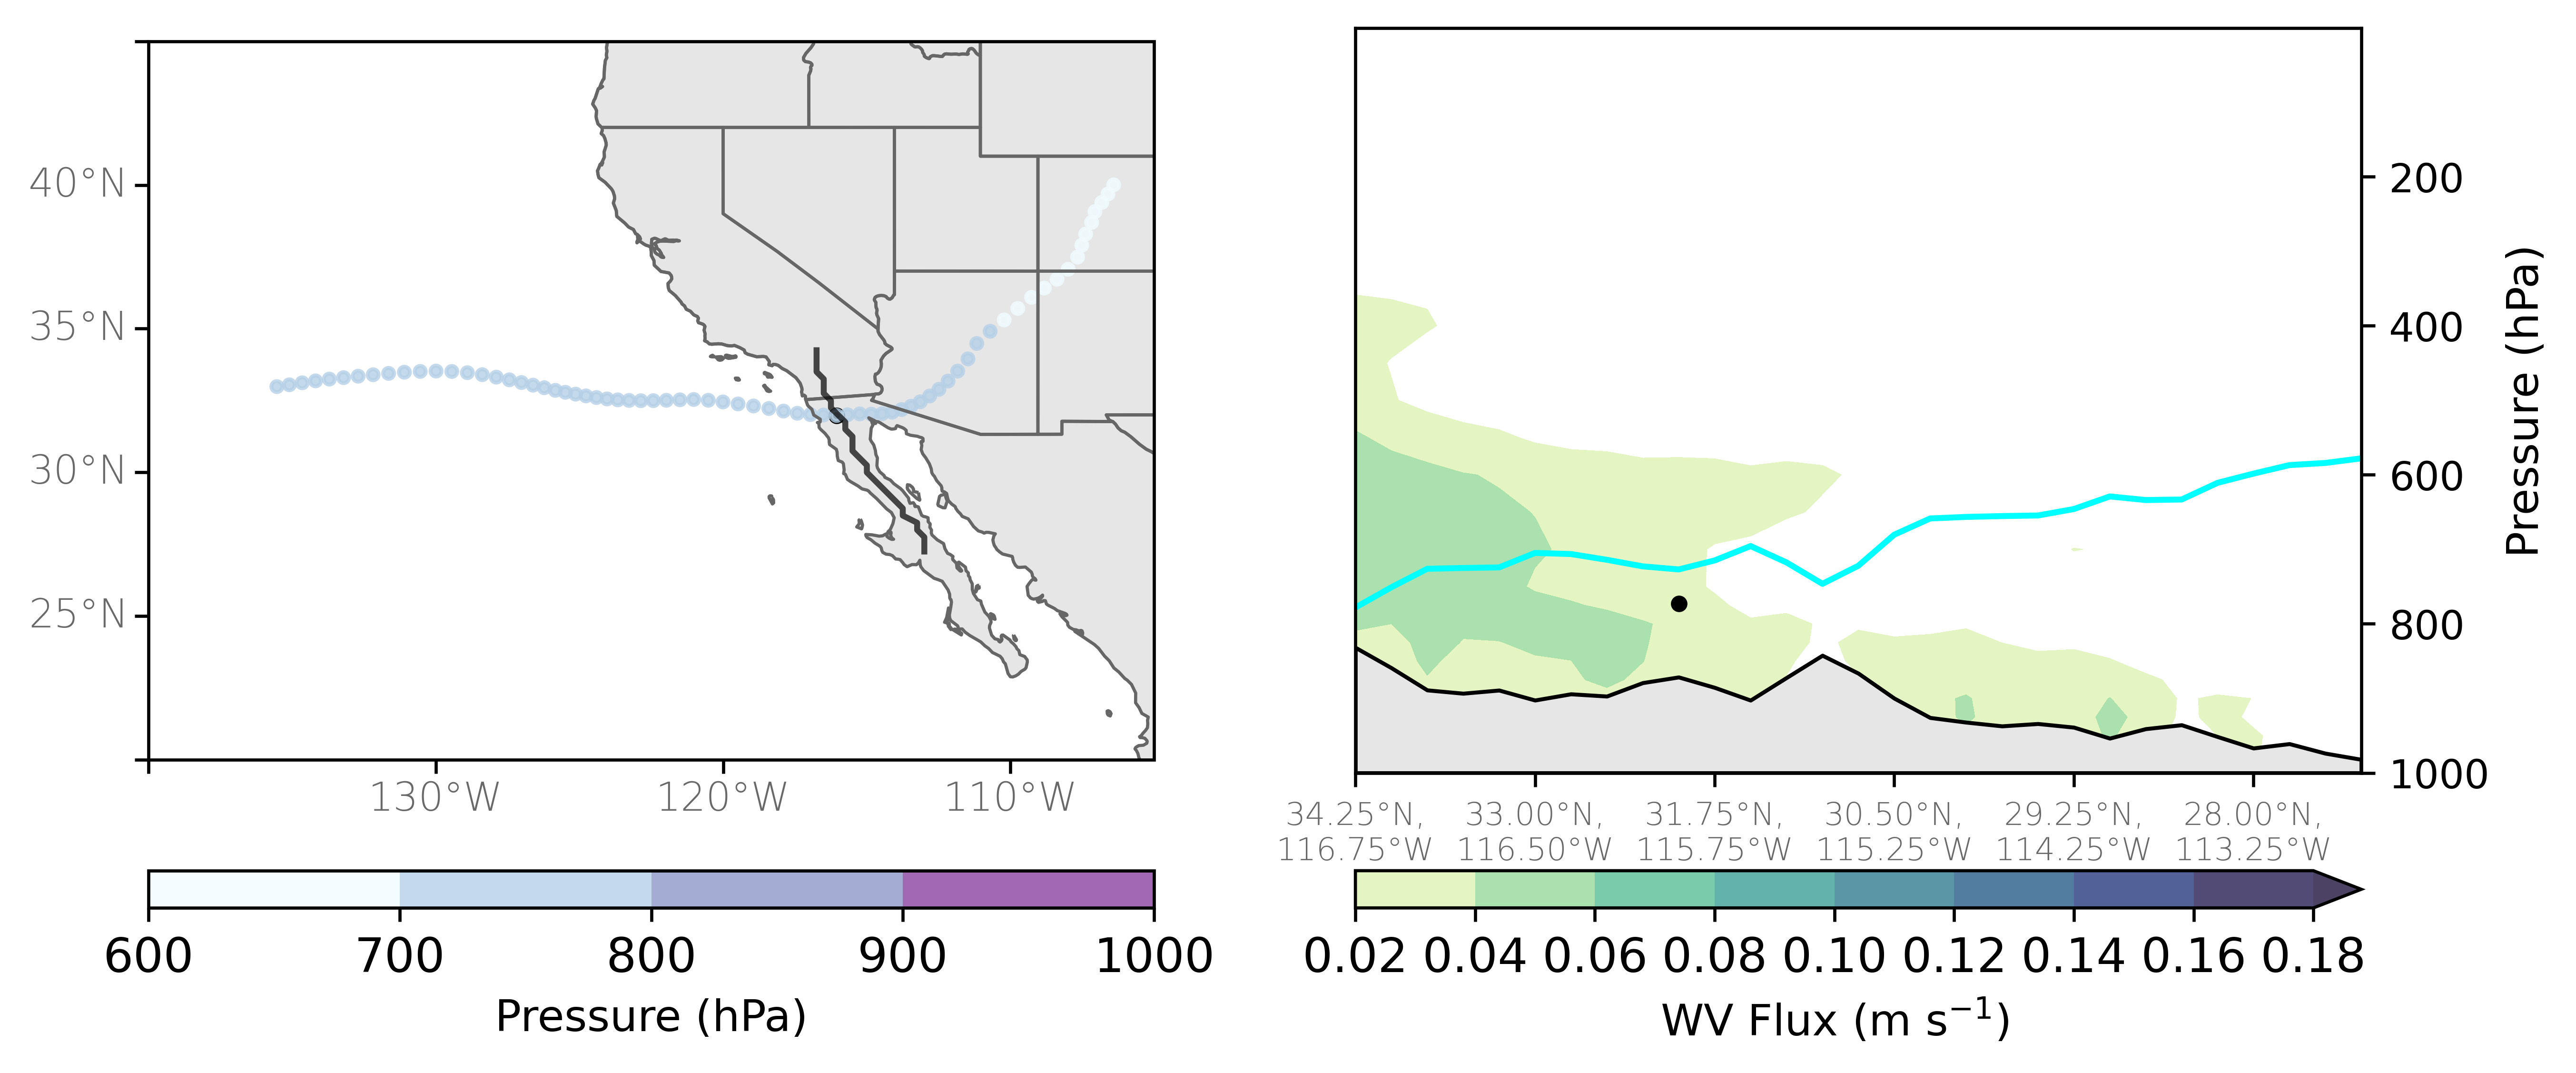

In [20]:
nrows = 2
ncols = 2
kw_ticklabels = {'size': 8, 'color': 'dimgray', 'weight': 'light'}
## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 0.05], width_ratios = [1, 1], wspace=0.2, hspace=0.25)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(10.0, 4.0))
fig.dpi = 600
fname = path_to_figs + 'Jan2023_case_trajectory'
fmt = 'png'

############################
### PLOT IVT VALUES ###
############################
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in
ext = [-140., -105., 20., 45.]
# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

ax = fig.add_subplot(gs[0, 0], projection=mapcrs)
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False)
ax.set_extent(ext, datacrs)
## topo with gray shading
# cs = plot_terrain(ax, ext)
ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

# add point where trajectory crosses transect
ax.scatter(ds.longitude.values[0][0][29], ds.latitude.values[0][0][29], c='k', marker='.', transform=datacrs, alpha=1, s=40)

## add trajectory points, colored by pressure
data = ds
y_lst = data.latitude.values
x_lst = data.longitude.values
z_lst = data.level.values
# ax.plot(x_lst, y_lst, c='gray', transform=datacrs, alpha=0.2)
cmap, norm, bnds = ccmap.cmap('pressure')
cf = ax.scatter(x_lst, y_lst, c=z_lst, cmap=cmap, norm=norm, marker='.', transform=datacrs, alpha=0.8, s=30)

## add elevation cross section points
# cf2 = ax.scatter(test.longitude.values, test.latitude.values, c='k', marker='.', transform=datacrs, alpha=0.8, s=30)
ax.plot(test.longitude.values, test.latitude.values, c='k', transform=datacrs, alpha=0.7)

# Add color bar
# cbarticks = norm[::1]
cbax = plt.subplot(gs[1,0]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('Pressure (hPa)', fontsize=11)
cb.ax.tick_params(labelsize=12)

## mock up a vertical cross section
## y-axis is pressure
## x-axis are the points
ax = fig.add_subplot(gs[0, 1])
xs = np.arange(0, len(test.location), 1) # how many coordinate values
ys = wv_flux.level.values
# terline = test.values
terline = sp.sp.values / 100
ht_fill = ax.fill_between(xs, 1000, terline, facecolor='0.9', edgecolor='k', zorder=10)

# Filled contours (WV flux)
cflevs = np.arange(0.02, 0.20, 0.02)
clipcmap = cmocean.tools.crop_by_percent(cmo.deep, 10, which='max', N=None)
cf = ax.contourf(xs, ys, wv_flux.values, levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max', zorder=-1)
plt.gca().invert_yaxis()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_ylabel("Pressure (hPa)", fontsize=11)

## add trajectory point
x = 9
y = ds.level.values[0][0][29]
ax.scatter(x, y, c='k', marker='.',  alpha=1, s=40)

## add freezing level
freeze_line = ax.plot(xs, deg0l, c='cyan', lw=1.5)

x_ticks = np.arange(len(xs))
x_labels = [u"{:.2f}\N{DEGREE SIGN}N, {:.2f}\N{DEGREE SIGN}W".format(wv_flux.latitude.values[i], wv_flux.longitude.values[i]*-1) for i in x_ticks]
# set the frequency of xtick labels
skip = 5
ax.set_xticks(x_ticks[0::skip])
ax.set_xticklabels([textwrap.fill(label, 8) for label in x_labels[0::skip]], fontsize=6, **kw_ticklabels)

# Add color bar
# cbarticks = norm[::1]
cbax = plt.subplot(gs[1,1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('WV Flux (m s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()